In [1]:
import sys
from hashlib import sha512
from pathlib import Path

import h5py as h5
import numpy as np
import pandas as pd

sys.path.append('../lib')
from storage import get_storage_functions
from local_paths import preproc_dir, eye_latency_calib_paths

In [2]:
#============================================================================
# session
#============================================================================
sess_name = 'sess_name'

#============================================================================
# main
#============================================================================
fr_change_frac_thres = .5

#============================================================================
# paths
#============================================================================
proc_dir = preproc_dir
output_dir = preproc_dir
overwrite = False  # overwrite any existing results; use with caution

In [3]:
# Parameters
sess_name = "Pa210201"


# Check parameters and whether already done

In [4]:
preproc_main_path = Path(proc_dir) / (sess_name + '-main.nwb')
rasters_path = Path(proc_dir) / (sess_name + '-rasters.nwb')
print('Loading session from', preproc_main_path)
print('Loading rasters from', rasters_path)
preproc_main_path = preproc_main_path.expanduser()
rasters_path = rasters_path.expanduser()
assert preproc_main_path.is_file()
assert rasters_path.is_file()

print('Using eye tracker latency calibration in:\n\t'+'\n\t'.join(map(str,eye_latency_calib_paths)))
eye_latency_calib_paths = tuple(Path(v).expanduser() for v in eye_latency_calib_paths)
assert all(v.is_file() for v in eye_latency_calib_paths)

output_dir = Path(output_dir)
assert output_dir.expanduser().is_dir()
output_path = output_dir / (sess_name + '-proc.h5')
print('Saving results to', output_path)
output_path = output_path.expanduser()

Loading session from ../test_data/Pa210201-main.nwb
Loading rasters from ../test_data/Pa210201-rasters.nwb
Using eye tracker latency calibration in:
	../db/sess_rig_info.csv
	../db/rig_eye_latency.csv
Saving results to ../test_data/Pa210201-proc.h5


In [5]:
if not overwrite and output_path.is_file():
    with h5.File(output_path, 'r') as f:
        try:
            if f['progress_report/shared_processing/all_done'][()].item():
                raise RuntimeError(f'{sess_name} has already been processed')
        except KeyError:
            pass

In [6]:
save_results, add_attr_to_dset, check_equals_saved, link_dsets, copy_group = \
    get_storage_functions(output_path, overwrite=overwrite)

# Main

### Save a default random seed (per-session, deterministic)

In [7]:
random_seed = int(sha512(bytes(sess_name, 'utf-8')).hexdigest()[-8:], 16)
print('random_seed:', random_seed)
save_results('config/default_random_seed', random_seed)

random_seed: 775418045


### Save image size

In [8]:
with h5.File(preproc_main_path, 'r') as f:
    im_size_px = f['stimulus/templates/stimuli/dimension'][()]
    stim_desc = f['general/stimulus'][()].decode()

print('stimuli:', stim_desc)
ppd = stim_desc.split('pix per degree')[0].split('[')[-1].strip('] ').split(',')
ppd = np.array(list(map(float, ppd)))
im_size_dva = np.round(im_size_px / ppd, 1)

print('image size (pixels):', im_size_px)
print('image size (dva):', im_size_dva)

stimuli: [635, 635] pixels at [39.71, 39.71] pix per degree; 150 unique location(s)
image size (pixels): [635 635]
image size (dva): [16. 16.]


In [9]:
save_results('stimulus/size_px', im_size_px)
save_results('stimulus/size_dva', im_size_dva)
save_results('stimulus/pixels_per_degree', ppd)

### Save stimulus folder(s): root and any subdirs

In [10]:
with h5.File(preproc_main_path, 'r') as f:
    uim_paths = f['stimulus/templates/stimuli/external_file'][()].astype(str)

# find longest shared root dir
if any('\\' in v for v in uim_paths):  # Windows paths
    uim_subds = np.char.split(uim_paths, '\\')
else:
    uim_subds = np.char.split(uim_paths, '/')
for i in range(min(map(len, uim_subds))):
    if len(set(v[i] for v in uim_subds)) > 1:
        i -= 1
        break

im_root = '/'.join(uim_subds[0][:i+1])
uim_fns = np.array([v[-1] for v in uim_subds])
uim_subds = np.array(['/'.join(v[i+1:-1]) for v in uim_subds])

In [11]:
save_results('stimulus/folder', im_root)
save_results('stimulus/subdirectories', np.array(sorted(set(uim_subds))).astype(bytes))

### Get (rig-specific, measured) eye latency

In [12]:
tracker, rig = pd.read_csv(eye_latency_calib_paths[0], converters={'Eye tracker': str})\
    .set_index('Name').loc[sess_name][['Eye tracker', 'Rig']]
tracker = tracker.split(' ')[-1]
tracker_latency = pd.read_csv(eye_latency_calib_paths[1], converters={'Tracker': str})\
    .set_index(['Rig', 'Tracker']).loc[(rig, tracker)]['Latency']
tracker_latency_rule = f'rig {rig}, tracker: {tracker}'
print(f'Correcting eye tracking timing by {tracker_latency} ms ({tracker_latency_rule})')

Correcting eye tracking timing by 5 ms (rig 2, tracker: EyeLink)


In [13]:
save_results('config/eye_tracking_latency', tracker_latency, attrs=dict(unit='ms'))
save_results('config/eye_tracking_latency_rule', tracker_latency_rule)

### Save formatted fixations

In [14]:
fix_df = {'Time': 'start_time', 'End time': 'stop_time', 'Trial': 'trial_id', 'Screen X': 'x', 'Screen Y': 'y'}
with h5.File(preproc_main_path, 'r') as f:
    try:
        group = f['processing/behavior/fixations']
    except KeyError:  # compat
        group = f['processing/fixation_detection/fixations']
    for k, v in fix_df.items():
        fix_df[k] = group[v][()]
        if k == 'Trial':
            fix_df[k] = fix_df[k].astype(int)  # pytables does not like uint64 as an index

fix_df = pd.DataFrame(fix_df)

Compensate for tracker latency before further formatting

In [15]:
fix_df['Time'] -= tracker_latency/1e3
fix_df['End time'] -= tracker_latency/1e3

Cross-reference fixations to stimulus presentations

In [16]:
with h5.File(preproc_main_path, 'r') as f:
    pres_iim = f['stimulus/presentation/presentations/data'][()]
    pres_tid = f['intervals/presentations/trial_id'][()]
    pres_t0s = f['intervals/presentations/start_time'][()]
    pres_t1s = f['intervals/presentations/stop_time'][()]
    pres_pos = f['intervals/presentations/position'][()]

im_fns = uim_fns[pres_iim]
im_subdirs = uim_subds[pres_iim]
pres_df = pd.DataFrame({
    'Trial': pres_tid,
    'Start time': pres_t0s,
    'End time': pres_t1s,
    'X': pres_pos[:,0],
    'Y': pres_pos[:,1],
    'Image filename': im_fns,
    'Image subdir': im_subdirs,
}).set_index('Trial')

In [17]:
# not all fixations were during image presentation; select those that overlap in part with pres time
fix_df = fix_df[fix_df['Trial'].isin(pres_tid)]
pres_df_ = pres_df.loc[fix_df['Trial']]
in_pres = (
    ((fix_df['End time'].values - pres_df_['Start time'].values) > 0)
    & ((fix_df['Time'].values - pres_df_['End time'].values) <= 0)
)
fix_df = fix_df[in_pres]
pres_df_ = pres_df.loc[fix_df['Trial']]

# find and clip fixations across stim onset to onset time
is_zeroth = fix_df['Time'].values <= pres_df_['Start time'].values
fix_df.loc[is_zeroth, 'Time'] = pres_df_.loc[is_zeroth, 'Start time'].values

# cast presentation-specific info to fixations
fix_df[['Relative X', 'Relative Y']] = fix_df[['Screen X', 'Screen Y']] - pres_df_[['X', 'Y']].values
fix_df[['Image filename', 'Image subdir']] = pres_df_[['Image filename', 'Image subdir']].values

# add order of fixation in each trial
fix_df['Fixation'] = pd.concat([
    pd.Series(data=np.argsort(g['Time'])+1, index=g.index)
    for _, g in fix_df.groupby('Trial')
])
# order starts with 0 only for trials containing a "zeroth fixation"; 1 otherwise
m = fix_df['Trial'].isin(fix_df[is_zeroth]['Trial'])
fix_df.loc[m, 'Fixation'] -= 1

# add duration, time-since-stim-on; convert time s -> ms
fix_df['Duration'] = fix_df['End time'] - fix_df['Time']
fix_df['Trial time'] = fix_df['Time'] - pres_df_['Start time'].values
assert (fix_df['Trial time'][fix_df['Fixation'] == 0] == 0).all()  # sanity checks
assert (fix_df['Trial time'][fix_df['Fixation'] != 0] > 0).all()
fix_df['Trial time'] = np.clip(fix_df['Trial time'], 0, None)
fix_df[['Time', 'Trial time', 'End time', 'Duration']] *= 1e3

# drop irrelevant columns; set index
fix_df = fix_df.drop(columns=['Screen X', 'Screen Y'])
fix_df = fix_df.set_index(['Trial', 'Fixation'])

# add ref to prev fixation
ipre = np.full(len(fix_df), -1, dtype=int)
for i, (itr, ifix) in enumerate(fix_df.index):
    try:
        ipre[i] = fix_df.index.get_loc((itr, ifix-1))
    except KeyError:
        pass
fix_df['Preceding fixation index'] = ipre

print(fix_df.shape)
fix_df.head()

(6927, 9)


Time  End time  Relative X  Relative Y   
Trial Fixation                                               
1     0         1576.000  1702.225   -1.433481    6.472321  \
      1         1741.225  1868.225    4.569738    1.968158   
      2         1889.225  2224.225    4.253864   -0.526914   
      3         2250.225  2781.225    6.457235    2.498425   
      4         2819.225  3072.225   -0.096668    5.759803   

                                      Image filename Image subdir  Duration   
Trial Fixation                                                                
1     0         7cadf8b2db81d6c8d411af1ee7de842a.jpg                126.225  \
      1         7cadf8b2db81d6c8d411af1ee7de842a.jpg                127.000   
      2         7cadf8b2db81d6c8d411af1ee7de842a.jpg                335.000   
      3         7cadf8b2db81d6c8d411af1ee7de842a.jpg                531.000   
      4         7cadf8b2db81d6c8d411af1ee7de842a.jpg                253.000   

                Trial time  Preceding fixation index  
Trial Fixation                                        
1     0              0.000                        -1  
      1            165.225                         0  
      2            313.225                         1  
      3            674.225                         2  
      4           1243.225                         3

In [18]:
fix_df.to_hdf(output_path, 'fixation_dataframe', mode='a', format='table', complevel=9, complib='zlib')

### Select neurons

Using minimal criteria to only exclude clearly technical problems:
1. FR in 2nd half of data must not be 0 (if so, it is most likely the unit was lost)
2. FR in 2nd half of data must not be > 150% or < 50% of overall FR (if so, it is most likely the unit was not stable)

Criteria more meaningful for downstream analysis (e.g., visual responsiveness) can be applied downstream.

In [19]:
with h5.File(rasters_path, 'r') as f:
    unit_names = f['processing/ecephys/unit_names/unit_name'][()].astype(str)
    rasters = f['processing/ecephys/rasters/data'][()]
duration = len(rasters)
all_unit_names = unit_names.copy()

l = rasters.shape[0]
fr = rasters.mean(0)*1e3
fr1 = rasters[l//2:].mean(0)*1e3

dfr = fr1 / fr - 1

m0 = fr1 == 0
m1 = np.abs(dfr) > fr_change_frac_thres
m = m1|m0

print('total', m.size, 'units:')
print(f'excluding {m0.sum()} ({m0.mean()*100:.1f}%) unit(s) without spikes in second half of recording')
print(f'excluding {m1.sum()} ({m1.mean()*100:.1f}%) unstable unit(s)')
print(f'excluding {m.sum()} ({m.mean()*100:.1f}%) total unit(s)')
unit_names = unit_names[~m]
print('keeping', (~m).sum(), 'units:')
print('\t' + '\n\t'.join(str(unit_names).split('\n')))

total 92 units:
excluding 0 (0.0%) unit(s) without spikes in second half of recording
excluding 0 (0.0%) unstable unit(s)
excluding 0 (0.0%) total unit(s)
keeping 92 units:
	['1' '2' '3' '4' '4a' '4b' '4c' '4d' '5' '6' '6a' '6b' '7' '8' '9' '10'
	 '10a' '10b' '11' '12' '13' '14' '15' '15a' '15b' '16' '16a' '16b' '17'
	 '18' '19' '20' '21' '22' '23' '23a' '23b' '24' '25' '26' '27' '27a' '27b'
	 '27c' '28' '29' '30' '31' '32' '33' '33a' '33b' '34' '35' '36' '37' '38'
	 '39' '40' '41' '42' '42a' '42b' '43' '44' '45' '46' '47' '48' '48a' '48b'
	 '49' '50' '51' '52' '53' '54' '54a' '54b' '55' '55a' '55b' '55c' '56'
	 '57' '58' '59' '60' '61' '62' '63' '64']


In [20]:
save_results('recording_duration', duration, attrs=dict(unit='ms'))
save_results('config/unit_selection/fr_change_frac_thres', fr_change_frac_thres)
save_results('unit_selection/all', all_unit_names.astype(bytes))
save_results('unit_selection/simple', unit_names.astype(bytes))

### Calculate response stats
I.e., response mean and stdev, during stimulus and inter-stimulus periods respectively

In [21]:
is_stim = np.zeros(len(rasters), dtype=bool)
for t0, t1 in np.round(np.array([pres_t0s, pres_t1s]).T).astype(int):
    is_stim[t0:t1] = True
byper_mean_std = np.empty((2, 2, rasters.shape[1]))
for iper in range(2):
    m = is_stim if iper else ~is_stim
    vals = rasters[m]
    byper_mean_std[iper, 0] = vals.mean(0) * 1e3
    byper_mean_std[iper, 1] = vals.std(0) * 1e3

In [22]:
save_results(
    'response_stats/stim_spont_mean_std',
    byper_mean_std,
    attrs=dict(
        dims=np.array(['period', 'statistic', 'unit'], dtype=bytes),
        period=np.array(['inter-stimulus', 'stimulus'], dtype=bytes),
        statistic=np.array(['mean', 'stdev'], dtype=bytes),
        unit=all_unit_names.astype(bytes),
        num_ms=np.array([(~is_stim).sum(), is_stim.sum()]),
        unit_='spikes/s',
    )
)

# Wrap up

In [23]:
save_results('progress_report/shared_processing/all_done', True)

In [24]:
%load_ext watermark
%watermark -vm --iversions -rbg

Python implementation: CPython
Python version       : 3.10.12
IPython version      : 8.12.0

Compiler    : GCC 11.4.0
OS          : Linux
Release     : 5.15.0-92-generic
Machine     : x86_64
Processor   : x86_64
CPU cores   : 20
Architecture: 64bit

Git hash: b0bb10f45dee065cc3af96fe224326b883d27431

Git repo: https://github.com/willwx/free_viewing_staging.git

Git branch: master

sys   : 3.10.12 (main, Nov 20 2023, 15:14:05) [GCC 11.4.0]
pandas: 2.0.1
numpy : 1.24.3
h5py  : 3.8.0



# Quick plots

In [25]:
import matplotlib.pyplot as plt

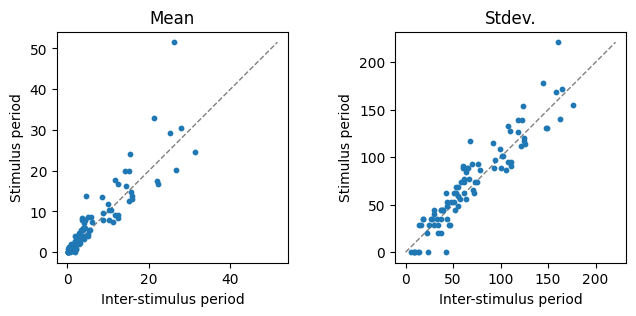

In [26]:
fig, axs = plt.subplots(1, 2, figsize=(8,3))

for i, ax in enumerate(axs):
    vals = byper_mean_std[:,i]

    ax.scatter(*vals, s=10)
    u, l = vals.min(), vals.max()
    ax.set_aspect('equal')
    ax.plot([u,l], [u,l], lw=1, ls='--', zorder=-1, color='gray')
    if i == 0:
        ax.set_title('Mean')
    else:
        ax.set_title('Stdev.')
    ax.set_xlabel('Inter-stimulus period')
    ax.set_ylabel('Stimulus period')